In [2]:
import os
import datetime
import json
import matplotlib.pyplot as plt
import gc

import pandas as pd
import numpy as np

from os import listdir
from sklearn.linear_model import LogisticRegression

from datetime import datetime
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import ClusterCentroids
from sklearn.model_selection import train_test_split


from sklearn import linear_model
import pickle
from sklearn import svm

import seaborn as sns
import csv

In [3]:
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Import different stemmers - Lancaster, Porter
LCst = nltk.LancasterStemmer()
PRst = nltk.PorterStemmer()
lemma = nltk.wordnet.WordNetLemmatizer()
#sno = nl.stem.SnowballStemmer('english')
#lemma.lemmatize('article')


In [5]:
# Read sentiment dictionary

def dictRead(file):
    arr=[]
    mycommand = "perl -p -i.back -e 's/\t/\,/g'"
    cmd = mycommand+' '+file
    os.system(cmd)

    hm = {}
    with open(file, 'r') as infile:
        reader = csv.reader(infile)
        for row in reader:

            key = row[0].strip("'")
            value = int(row[1])


            arr.append(row)
            hm[key] = value


    return hm

sent_file = "AFINN-111.txt"
sent_map = dictRead(sent_file)

In [6]:
def getSentimentScore(lst,sent_dict):
    sum_rnk=0
    wrdCnt = len(lst)
    
    for w in lst:
        word = w.lower().strip(' \t\n\r')
        #word_root =     
        cnt=0
        if  word in sent_dict:
            rnk = int(sent_dict[word])
        else:
            rnk = 0
        sum_rnk = sum_rnk + rnk

    rank = sum_rnk
    
    return rank


In [7]:
dsHappy = pd.read_csv('~/data/hotel_happy_reviews.csv')

In [8]:
dsNotHappy = pd.read_csv('~/data/hotel_not_happy_reviews.csv')

In [9]:
# create dataset for all reviews
dsAll = pd.concat([dsHappy,dsNotHappy], axis = 0)

In [10]:
# Assigning labels: 1 - Happy, 0  - Not Happy
dsAll['label']  = [1 if x=='happy' else 0 for x in dsAll.Is_Response]
label = dsAll['label']



In [11]:
reviewsByHotel = dsAll.groupby(by = ['hotel_ID','label']).count().rename(columns = {'Is_Response':'count'})
reviewsByHotel ['hotel_ID'] = reviewsByHotel.index.get_level_values(0)
reviewsByHotel ['label'] = reviewsByHotel.index.get_level_values(1)



In [12]:
reviewsByHotel = reviewsByHotel[['hotel_ID','label','count']]

# EDA

### Number of positive and negative reviews

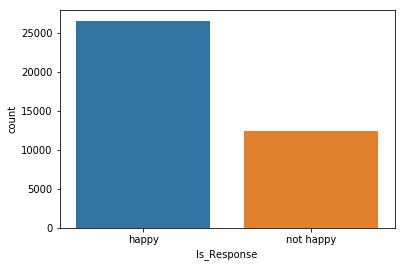

In [13]:
ax = sns.countplot(x="Is_Response", data=dsAll)

### Distribution of reviews by hotels

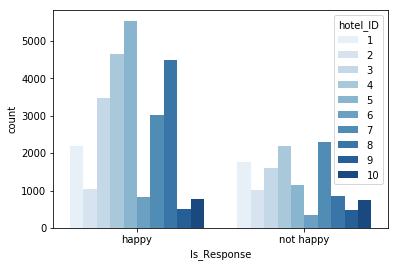

In [14]:
ax = sns.countplot(x="Is_Response", hue="hotel_ID", data=dsAll, palette = "Blues")

Distribution of Happy / Not Happy reviews by hotel


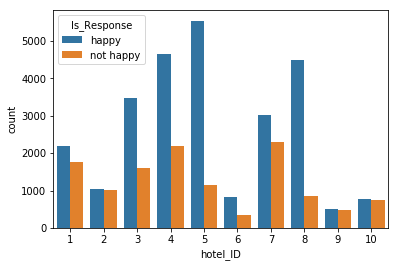

In [15]:
ax = sns.countplot(x="hotel_ID", hue="Is_Response", data=dsAll)
print ("Distribution of Happy / Not Happy reviews by hotel")

### Number of reviews per hotel

Reviews by hotel


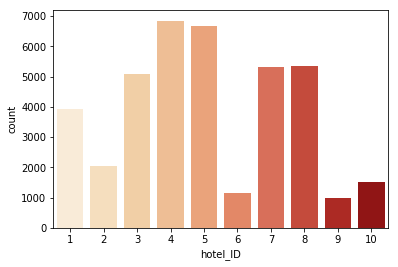

In [16]:
ax = sns.countplot(x="hotel_ID", data=dsAll,palette = 'OrRd')
print ("Reviews by hotel")

### Split data into train and test datasets

In [17]:
#Split dataset into train and test
X_train,X_test, y_train, y_test = train_test_split(dsAll,dsAll['label'], test_size=0.33)




In [18]:
# Create dictionary of reviews by hotel = for Happy reviews
def createReviewDictionary(ds):
    dict_by_hotels = {k: v for k, v in ds.groupby('hotel_ID')}

    for key in dict_by_hotels:
        dict_by_hotels[key] = pd.DataFrame(dict_by_hotels[key], columns=['Description'])

    #convert df to a list

    for key in dict_by_hotels:
        dict_by_hotels[key] = dict_by_hotels[key].values.tolist()
    
    
    arrByHotels=[]
    for key,value in dict_by_hotels.items():
        arrByHotels.append([key,value])
    
    df = pd.DataFrame(arrByHotels).rename(columns = {0:'ID',1:'text'})
    return df,dict_by_hotels


In [19]:
X_Happy = X_train[X_train.label ==1]
X_NotHappy = X_train[X_train.label ==0]

dsHappyByHotels, dsHappyByHotels_dict = createReviewDictionary(X_Happy.sample(n=300))
dsNotHappyByHotels, dsNotHappyByHotels_dict= createReviewDictionary(X_NotHappy.sample(n=300))

In [20]:
X_Happy_Test = X_test[X_test.label ==1]
X_NotHappy_Test = X_test[X_test.label ==0]

dsHappyByHotels_test, dsHappyByHotels_dict_test = createReviewDictionary(X_Happy_Test.sample(n=300))
dsNotHappyByHotels_test, dsNotHappyByHotels_dict_test= createReviewDictionary(X_NotHappy_Test.sample(n=300))

## Preproccessing text

In [55]:
stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

def preprocess_(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS :
            result.append(token)
    return result

In [56]:

def cleanText(df):
    df['sentences'] = [str(x).replace(r"\r\n", " ") for x in df.text]
    df['sentences'] = [re.sub("[@#$%^&*()[]{};:/<>?\|`~-=_+]", ' ', x) for x in df.sentences]
    
    df['text'] = [re.sub("[^a-zA-Z0-9\n\.]", ' ', x) for x in df.sentences]
    df['text'] = [re.sub("[A-Z][A-Za-z]*", ' ', x) for x in df.text]    
    df['text'] = [re.sub("\W+", ' ', x) for x in df.text]

    df['sentences'] = [re.sub('[^a-zA-Z]', ' ', x ) for x in df.sentences]
    df['sentences'] = [re.sub(r'\s+', ' ', x) for x in df.sentences]

    # Preparing the dataset
    df['preprocessedWrdLst'] = [preprocess(x) for x in df.text]
    
    return df


### Process data for happy and not happy reviews

In [57]:
dsHappyByHotels = cleanText(dsHappyByHotels)
dsNotHappyByHotels = cleanText(dsNotHappyByHotels)

dsHappyByHotels_test = cleanText(dsHappyByHotels_test)
dsNotHappyByHotels_test = cleanText(dsNotHappyByHotels_test)



### Get corpus as bag of words and tfidf

In [92]:
def getCorpus(df,col):
    dictionary = gensim.corpora.Dictionary(df[col])
    dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)
    
    corpus = [dictionary.doc2bow(doc) for doc in df[col]]
    
    tfidf = models.TfidfModel(corpus)

    corpus_tfidf = tfidf[corpus]

    
    return dictionary,corpus,corpus_tfidf 



In [93]:
dictionaryHappy,corpusHappy,corpusHappy_tfidf = getCorpus(dsHappyByHotels,'preprocessedWrdLst')
dictionaryNotHappy,corpusNotHappy,corpusNotHappy_tfidf = getCorpus(dsNotHappyByHotels,'preprocessedWrdLst')

### Save data to files

In [587]:
dsHappyByHotels.to_hdf('~/data/hotelHappy.h5', key='dsHappyByHotels', mode='w')
dsNotHappyByHotels.to_hdf('~/data/hotelNotHappy.h5', key='dsNotHappyByHotels', mode='w')

### LDA Multicore (Gensim)

In [169]:
def getTopics(corpus,corpus_tfidf,dictionary): 
    lda_model = gensim.models.LdaMulticore(corpus, num_topics=10, id2word=dictionary, passes = 2, workers = 5) 
    lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=5)
    return lda_model,lda_model_tfidf

In [170]:
#Happy reviews
lda_modelHappy,lda_modelHappy_tfidf = getTopics(corpusHappy,corpusHappy_tfidf,dictionaryHappy)


In [171]:
#Not Happy reviews
lda_modelNotHappy,lda_modelNotHappy_tfidf = getTopics(corpusNotHappy,corpusNotHappy_tfidf,dictionaryNotHappy)



## Print out topics

### Happy reviews

In [172]:

for idx, topic in lda_modelHappy.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))
    #print('Words: {}'.format(topic))



Topic: 0 
Words: 0.031*"second" + 0.029*"main" + 0.025*"cozi" + 0.022*"money" + 0.021*"decid" + 0.020*"read" + 0.019*"sign" + 0.019*"pillow" + 0.018*"overal" + 0.016*"step"
Topic: 1 
Words: 0.027*"pillow" + 0.026*"water" + 0.016*"charg" + 0.015*"towel" + 0.014*"tri" + 0.014*"doubl" + 0.014*"pleasant" + 0.014*"overal" + 0.014*"money" + 0.013*"forget"
Topic: 2 
Words: 0.021*"type" + 0.020*"absolut" + 0.018*"averag" + 0.018*"doubl" + 0.017*"town" + 0.017*"charg" + 0.017*"call" + 0.016*"concierg" + 0.016*"chees" + 0.015*"touch"
Topic: 3 
Words: 0.017*"read" + 0.015*"internet" + 0.014*"cheap" + 0.013*"train" + 0.013*"sofa" + 0.013*"absolut" + 0.013*"step" + 0.013*"end" + 0.012*"concierg" + 0.012*"main"
Topic: 4 
Words: 0.060*"avoid" + 0.026*"nearbi" + 0.025*"loung" + 0.024*"immedi" + 0.023*"buffet" + 0.023*"snack" + 0.023*"proxim" + 0.022*"minibar" + 0.022*"heat" + 0.022*"flat"
Topic: 5 
Words: 0.078*"concierg" + 0.051*"doormen" + 0.029*"transport" + 0.029*"squar" + 0.028*"pack" + 0.028*"ap

### Not Happy reviews

In [173]:
for idx, topic in lda_modelNotHappy.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))
    #print('Words: {}'.format(topic))



Topic: 0 
Words: 0.025*"checkout" + 0.023*"report" + 0.022*"happen" + 0.021*"remodel" + 0.021*"twice" + 0.021*"relat" + 0.019*"site" + 0.017*"closet" + 0.017*"aren" + 0.017*"cigarett"
Topic: 1 
Words: 0.020*"site" + 0.019*"corner" + 0.015*"pillow" + 0.013*"drawer" + 0.013*"chain" + 0.013*"closet" + 0.013*"treat" + 0.013*"wash" + 0.012*"cabl" + 0.012*"fulli"
Topic: 2 
Words: 0.031*"bag" + 0.021*"bug" + 0.021*"pillow" + 0.019*"mini" + 0.016*"claim" + 0.016*"report" + 0.015*"sight" + 0.015*"attempt" + 0.015*"rough" + 0.014*"dust"
Topic: 3 
Words: 0.024*"closet" + 0.021*"glass" + 0.020*"happen" + 0.018*"claim" + 0.016*"mind" + 0.016*"pillow" + 0.015*"site" + 0.015*"ridicul" + 0.015*"twice" + 0.015*"corner"
Topic: 4 
Words: 0.031*"corner" + 0.021*"world" + 0.020*"drive" + 0.019*"speak" + 0.019*"switch" + 0.017*"spot" + 0.017*"tourist" + 0.015*"fulli" + 0.015*"negat" + 0.014*"discov"
Topic: 5 
Words: 0.016*"checkout" + 0.015*"happen" + 0.014*"bag" + 0.014*"state" + 0.013*"closet" + 0.013*"cl

### Save LDA models to files

In [66]:
from gensim.test.utils import datapath

# Save model to disk.
temp_file = datapath("lda_modelHappy")
lda_modelHappy.save(temp_file)

temp_file_NotHappy = datapath("lda_modelNotHappy")
lda_modelNotHappy.save(temp_file_NotHappy)

### LDA (sklean)

In [139]:

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups
from time import time

def print_top_words(model, feature_names, n_top_words,score):
    #print("Sentiment score: "+ str(score))
    for topic_idx, topic in enumerate(model.components_):
        features = [feature_names[i] for i in topic.argsort()[:100:-1]]
        #print(features)
        topicScore = getSentimentScore(features,sent_map)
        print("Sentiment score for "+str(topic_idx) +": "+ str(topicScore))
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
    
    
n_samples = 200
n_features = 100
n_components = 10
n_top_words = 10



In [174]:
# Function to extract topics by hotel
def runLDAbyHotel(data_samples,sent_map):
    
    n_samples = 200
    n_features = 100
    n_components = 10
    n_top_words = 10


    print("Extracting tf-idf features ...")
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
 
    tfidf = tfidf_vectorizer.fit_transform(data_samples)

    # Use tf (raw term count) features for LDA.
    print("Extracting tf features for LDA...")
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')

    tf = tf_vectorizer.fit_transform(data_samples)


    
    lda = LatentDirichletAllocation(n_components=n_components, max_iter=10,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

    lda.fit(tf)

    print("\nTopics in LDA model:")
    tf_feature_names = tf_vectorizer.get_feature_names()
    #print(tf_feature_names)
    
    score = getSentimentScore(tf_feature_names,sent_map)    
    print_top_words(lda, tf_feature_names, n_top_words,score)
    
    
    


In [175]:
def runLDAforAll(data_samples,sent_map):
    
    n_samples = 200
    n_features = 1000
    
    #number of topics
    n_components = 10
    n_top_words = 10


    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
 
    tfidf = tfidf_vectorizer.fit_transform(data_samples)

    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')

    tf = tf_vectorizer.fit_transform(data_samples)


    
    lda = LatentDirichletAllocation(n_components=n_components, max_iter=10,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

    lda.fit(tf)

    
    tf_feature_names = tf_vectorizer.get_feature_names()
    
    
    topicList = []
    for topic_idx, topic in enumerate(lda.components_):
        features = [tf_feature_names[i] for i in topic.argsort()[:1000]]
        featuresTop = [tf_feature_names[i] for i in topic.argsort()[:n_top_words]]
       
        topicList.append([topic_idx,features,featuresTop])
    
    df = pd.DataFrame(topicList).rename(columns={0:'num',1:'featureList',2:'topWords'})

    return df
  

### Get positive and negative topics for train data

In [176]:
#Get data for all hotels
def getAllText(df,col):
    data_samples = []
    for i in range(0,10):
       # print(df['preprocessedWrdLst'][i])
        data_samples = data_samples + df['preprocessedWrdLst'][i]
        
    return data_samples

data_samples_Happy = getAllText(dsHappyByHotels,'preprocessedWrdLst')
data_samples_NotHappy = getAllText(dsNotHappyByHotels,'preprocessedWrdLst')


In [177]:
topicListHappy = runLDAforAll(data_samples_Happy,sent_map)
topicListNotHappy = runLDAforAll(data_samples_NotHappy,sent_map)

In [180]:
print (topicListHappy[['num','featureList']])

   num                                        featureList
0    0  [roll, function, food, add, status, half, earl...
1    1  [uptown, exact, upgrad, great, fulli, impress,...
2    2  [approx, touristi, stupid, light, dryer, bus, ...
3    3  [sit, pay, includ, corner, aris, negat, reason...
4    4  [bus, budget, road, hour, attach, fan, pretti,...
5    5  [amen, appear, transfer, stylish, action, cler...
6    6  [hill, super, loud, complimentari, turn, larg,...
7    7  [sandwich, haven, feel, normal, renov, clean, ...
8    8  [happi, secur, chees, microwav, trust, door, s...
9    9  [dog, review, ask, shower, trail, metro, block...


In [179]:
print (topicListNotHappy[['num','featureList']])

   num                                        featureList
0    0  [season, consid, chang, effort, lose, fulli, c...
1    1  [week, season, safe, cockroach, continent, rea...
2    2  [bright, tini, relat, cockroach, shop, consid,...
3    3  [ridicul, bright, member, week, elev, okay, pl...
4    4  [sightse, tini, effort, steal, greet, problem,...
5    5  [lose, experi, amaz, consid, sightse, file, bu...
6    6  [consid, bright, style, safe, tini, member, lo...
7    7  [bright, lose, continent, safe, allow, amaz, p...
8    8  [tini, safe, recommend, heavi, consid, experi,...
9    9  [bright, lose, season, ridicul, conveni, relat...


In [128]:
happyWords = []
for i in range(0,10):
    happyWords = happyWords + dsHappyByHotels['preprocessedWrdLst'][i]
    
nothappyWords = []
for i in range(0,10):
    nothappyWords = nothappyWords + dsNotHappyByHotels['preprocessedWrdLst'][i]
    
#print(nothappyWords)

total_words= []
import collections
import matplotlib.cm as cm
from matplotlib import rcParams

#lst = happyWords 

def plotCommonWords(lst):
    
    filtered_words = [word for word in lst]
    counted_words = collections.Counter(filtered_words)
    words = []
    counts = []
    arr=[]
    for letter, count in counted_words.most_common(20):
        words.append(letter)
        counts.append(count)
    
        plt.title('Top words from reviews')
        plt.xlabel('Count')
        plt.ylabel('words')
        plt.barh(words, counts)
        arr.append([letter,count])
        
    return words


#total_words= total_words + words 

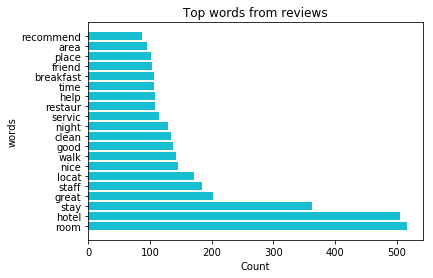

In [129]:
dfHappy = plotCommonWords(happyWords)



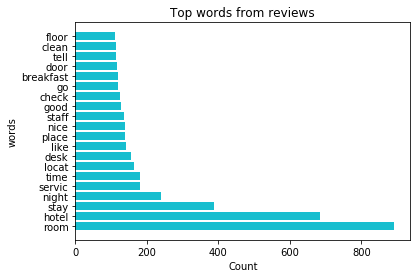

In [130]:
dfNotHappy = plotCommonWords(nothappyWords)

In [124]:
freqWords = list(set(dfNotHappy + dfHappy))
print(freqWords)

['help', 'recommend', 'like', 'great', 'breakfast', 'walk', 'night', 'friend', 'door', 'clean', 'servic', 'nice', 'time', 'staff', 'restaur', 'floor', 'locat', 'hotel', 'area', 'stay', 'check', 'place', 'room', 'tell', 'desk', 'good', 'go']


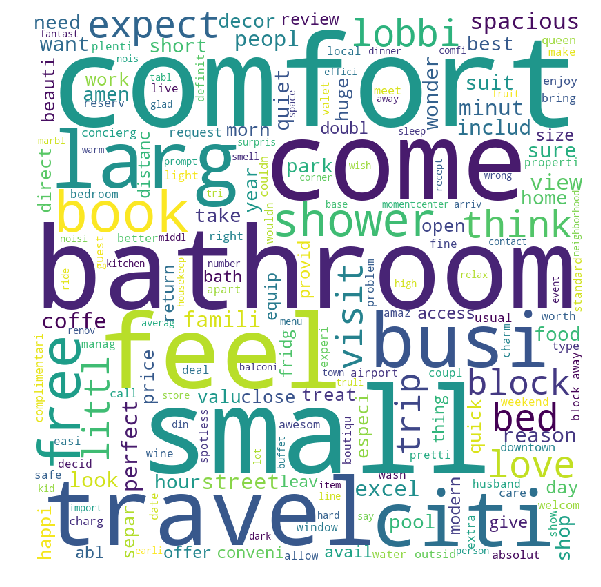

In [131]:
exclusionList = freqWords

dfHappy = dsHappyByHotels['preprocessedWrdLst'][4]
dfNotHappy = dsNotHappyByHotels['preprocessedWrdLst'][1]


allwordsHappy = ' '
for word in dfHappy:
    if word not in exclusionList:
        allwordsHappy = allwordsHappy + word+ ' '

allwordsNotHappy = ' '
for word in dfNotHappy:
    if word not in exclusionList:
        allwordsNotHappy = allwordsNotHappy + word+ ' '

    
    

from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(allwordsHappy) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 



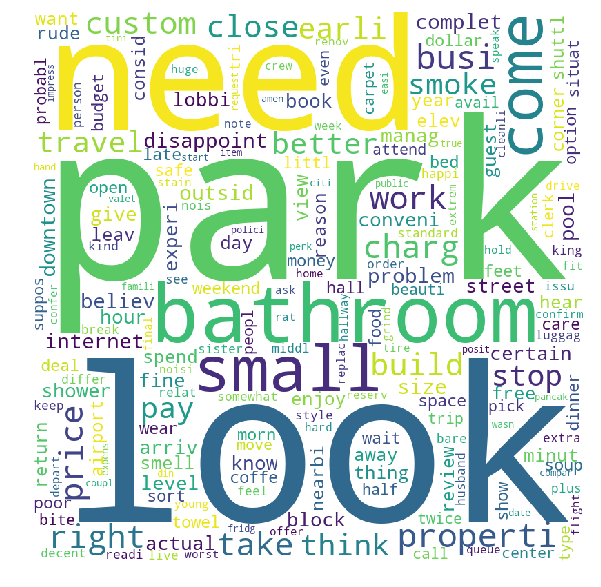

In [132]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(allwordsNotHappy) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Functions to calculate score for hotels by Topic

In [40]:

def getHotelScore(df,data_sample,sent_map,colName):
    scoreArr = []
    for ind,row in df.iterrows():
        lst = [value for value in data_sample if value in row['featureList'][:200]]
        #print(row['featureList'][:10])
        score = getSentimentScore(lst,sent_map) 
        scoreArr.append([ind,score])
        df = pd.DataFrame(scoreArr).rename(columns={0:'topicIdx',1: colName})
    
    return df

def getHotelScoresbyTopic(dsHappy,dsNotHappy,topicListHappy,topicListNotHappy,sent_map):
    arr =[]
    allScore = pd.DataFrame(columns=['hotel_ID','happyScore','notHappyScore'])
    for i in range(0,10):
        
        data_samplesHappy = dsHappy['preprocessedWrdLst'][i]
        data_samplesNotHappy = dsNotHappy['preprocessedWrdLst'][i]

    
        happyScore = getHotelScore(topicListHappy,data_samplesHappy,sent_map,'happyScore')
        notHappyScore = getHotelScore(topicListNotHappy,data_samplesNotHappy,sent_map,'notHappyScore')
    
        score = pd.merge(happyScore,notHappyScore, how = 'left', right_on = 'topicIdx', left_on = 'topicIdx')
        score['hotel_ID']=i
        
        allScore = pd.concat([allScore,score], axis = 0)
        #arr.append([i,happyScore,notHappyScore])
        #df = pd.DataFrame(arr).rename(columns = {0:'hotel_ID',1:'happyScore',2:'notHappyScore'})
        
    return allScore[['hotel_ID','topicIdx','happyScore','notHappyScore']]


dfHotelScore_test = getHotelScoresbyTopic(dsHappyByHotels_test,dsNotHappyByHotels_test,topicListHappy,topicListNotHappy,sent_map)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [42]:
dfHotelScore_test['topicIdx'] = [int(x) for x in dfHotelScore_test['topicIdx']]


#print(dfHotelScore_test[dfHotelScore_test.hotel_ID==4])
#print(dfHotelScore_test.sort_values(by = 'happyScore',ascending = False))


In [43]:
custom = topicListHappy[topicListHappy.num.isin([4,7])]

In [44]:
arr = []
for i in [4,7]:
    custom = topicListHappy[topicListHappy.num.isin([i])]
    arr.append(custom['topWords'])

pd.DataFrame(arr).to_csv('topicsHappy.csv')
dfHotelScore_test.to_csv('hotelScores.csv')

In [182]:
print(dfHotelScore_test[dfHotelScore_test.hotel_ID==4])

  hotel_ID  topicIdx happyScore notHappyScore
0        4         0        504           118
1        4         1        243           125
2        4         2        165           146
3        4         3        125            71
4        4         4        198            72
5        4         5        125           115
6        4         6         53           106
7        4         7        255           108
8        4         8        176            92
9        4         9        282           116


In [46]:

text = ''
for i in list(set(dsHappyByHotels['ID'])):
    #print(i)
    oneHotel = dsHappyByHotels[dsHappyByHotels.ID==i]
    text = text+' '+ oneHotel['text'][i-1]
    #print (text)

all_sentences = nltk.sent_tokenize(text)

all_words = [nltk.word_tokenize(sent) for sent in all_sentences]

In [47]:
#import gensim
from gensim.models import Word2Vec
sentences = []

#myModel = Word2Vec(all_words,min_count=5, size=100, window=3,  workers=5)
myModel = gensim.models.KeyedVectors.load_word2vec_format('~/data/GoogleNews-vectors-negative300.bin', binary=True)

#words = list(myModel.wv.vocab)
#print(words)




7    [return, heavy, ferry, different, read, spent,...
Name: topWords, dtype: object


In [192]:
# Output problematic topics - with lowest score 
customTopicHappy = topicListHappy[topicListHappy.num.isin([6])]
keysHappy = list(customTopicHappy['topWords'])

customTopicNotHappy = topicListNotHappy[topicListNotHappy.num.isin([3])]
keysNotHappy = list(customTopicNotHappy['topWords'])




[['hill', 'super', 'loud', 'complimentari', 'turn', 'larg', 'comfi', 'weight', 'clean', 'attent']]
[['ridicul', 'bright', 'member', 'week', 'elev', 'okay', 'plan', 'near', 'tini', 'freeway']]


In [193]:
print(keysHappy)

[['hill', 'super', 'loud', 'complimentari', 'turn', 'larg', 'comfi', 'weight', 'clean', 'attent']]


In [194]:
print(keysNotHappy)

[['ridicul', 'bright', 'member', 'week', 'elev', 'okay', 'plan', 'near', 'tini', 'freeway']]


## Conclusion and recommendation

I propose to divide the available reviews into two categories - positive and negative and for these categories do topics extractions using Latent Dirichlet Allocation model.
As a minimal viable product, I'm proposing selecting 10 topics by each category. I'm suggecting to use sentiment analysis then for each hotel to assaign the individual score within topic and based on the lowest scores suggest proactive actions for hotel managers.
Engineering challenges and pipelines: the best option is to run topic extraction algorithm each quarter and then calculate sentiment scores for hotels by topics. There is a chance the topics will differ as time pass. Ideally would be to store information from previos topics and compare the distance between the old and new sets of topics. And focus on the perfermance for the most similar topics in the reviews pool. Using rolling wondow for topic extraction would be also useful.
